# This code takes in a .csv file from TweetyBERT, then calculates phrase durations for each label. Then, it graphs the distribution of phrase durations across each day of annotated data.

## Import necesssary packages, calculate the time window length, load the .csv file, and check that there is only one animal's data in the .csv file. User needs to update/check:
1) .csv file path (line 23)
2) Update Surgery date (line 36)
2) time_window_length (if settings have changes from spectrograms input into TweetyBERT - these are copied and pasted from Slack mesage from George)
3) Check that the animal's ID matches your expectations!

In [54]:
#import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
import seaborn
from itertools import chain
import ast
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
## need to add stuff to get the .json file that will contain the settings of the spectrograms, time window duration, etc.
sampling_rate = 44100
NFFT = 1024
hop_length = 119
time_window_length = (hop_length / sampling_rate)
print(f"time_window_length: {time_window_length}")

# Load the data, and convert the labels from a string (from csv file) to a numpy array
annotation_data_frame = pd.read_csv('/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/2nd_set_of_song_databases/labels_USA5468_RC3_AreaXRose_database.csv')
print(annotation_data_frame['labels'])
# Surgery date (for example, '2024-03-31') (YYYY-MM-DD)
surgery_date = pd.to_datetime('2024-06-28')
print(f"Surgery date: {surgery_date}")

# Check if there is more than one animal's data
animal_ids = [file_name.split('_')[0] for file_name in annotation_data_frame['file_name']]
unique_animal_ids = set(animal_ids)
num_unique_animal_ids = len(unique_animal_ids)
print(f"animal_ids: {unique_animal_ids}")
if num_unique_animal_ids > 1:
    print("WARNING! YOU HAVE MORE THAN ONE ANIMAL'S DATA IN THIS .CSV FILE!!!")


## make a folder where the code will save the output graphs
save_figures_TF = True
where_to_save_graphs = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/song_databases/'
if save_figures_TF == True:
    output_folder_name = f'{animal_ids[0]}_output_graphs'
    # Ensure the folder exists
    os.makedirs(output_folder_name, exist_ok=True)
    output_folder_path = f'/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/{animal_ids[0]}_output_graphs'
    print(output_folder_path)


time_window_length: 0.0026984126984126986
0      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...
1      [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...
2      [10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...
3      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...
4      [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...
                             ...                        
124    [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...
125    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...
126    [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...
127    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...
128    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...
Name: labels, Length: 129, dtype: object
Surgery date: 2024-06-28 00:00:00
animal_ids: {'USA5468'}
/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs


### Organize the data into arrays


In [55]:
# current columns in the .csv file: song_id,group_id,file_name,date_time,labels,syllable_labels,file_id,spectrogram
# Convert the 'date_time' column to datetime format
annotation_data_frame['date_time'] = pd.to_datetime(annotation_data_frame['date_time'], errors='coerce')
# Verify the conversion by checking the type again
recording_timestamps = annotation_data_frame['date_time']
# Extract only the date
recording_dates = recording_timestamps.dt.date
recording_times = recording_timestamps.dt.time

time_bin_syllable_labels = np.array(annotation_data_frame['labels'])
# Convert each element from a string to a list or array
converted_labels = [np.array(ast.literal_eval(label)) for label in time_bin_syllable_labels]


##FIGURE OUT HOW TO CALCULATE PHRASE DURATIONS USING FIRST LABEL
sample_labels = converted_labels[0]
print(type(sample_labels))  # Should print <class 'numpy.ndarray'>

label_diff = np.diff(sample_labels)
# Find the indices where the label changes (where the difference is non-zero)
phrase_transition_indices = np.where(label_diff != 0)[0]  # Add 1 to adjust for the diff being one element shorter

# Find the last index of labels
last_index_of_labels = len(sample_labels) - 1  # Subtract 1 because Python indexing begins at 0
print(f"Last index of labels: {last_index_of_labels}")

# Define end of phrase indices
end_of_phrase_indices = np.concatenate((phrase_transition_indices, [last_index_of_labels]))
print(f"End of phrase indices: {end_of_phrase_indices}")

# Define start of phrase indices
start_of_phrase_indices = end_of_phrase_indices[0:-1]  # Exclude the last element
first_index_of_labels = 0
start_of_phrase_indices = np.concatenate(([first_index_of_labels], start_of_phrase_indices))
print(f"Start of phrase indices: {start_of_phrase_indices}")

# Determine phrase identities
phrase_identities = sample_labels[end_of_phrase_indices]
print(f"Phrase identities: {phrase_identities}")

# Calculate phrase durations in terms of time bins
num_time_windows_of_phrases = end_of_phrase_indices - start_of_phrase_indices
print(f"Phrase durations (number of time bins): {num_time_windows_of_phrases}")

# Convert durations to seconds
phrase_durations = num_time_windows_of_phrases * time_window_length
print(f"Phrase durations converted to seconds: {phrase_durations}")


## Find the syllables identities' order and durations in the song, the update the annotation_data_frame with these data:
# Function to calculate phrase durations in time bins and in seconds for a given set of labels
def calculate_phrase_durations_and_identities(labels, time_window_length):
    # Convert the labels from string to numpy array
    sample_labels = np.array(ast.literal_eval(labels))
    
    # Calculate the differences between consecutive labels
    label_diff = np.diff(sample_labels)
    
    # Find the indices where the label changes (where the difference is non-zero)
    phrase_transition_indices = np.where(label_diff != 0)[0]
    
    # Find the last index of labels
    last_index_of_labels = len(sample_labels) - 1
    
    # Define end of phrase indices
    end_of_phrase_indices = np.concatenate((phrase_transition_indices, [last_index_of_labels]))
    
    # Define start of phrase indices
    start_of_phrase_indices = end_of_phrase_indices[0:-1]
    first_index_of_labels = 0
    start_of_phrase_indices = np.concatenate(([first_index_of_labels], start_of_phrase_indices))
    
    # Determine phrase identities
    phrase_identities = sample_labels[end_of_phrase_indices]
    
    # Calculate phrase durations in terms of time bins
    num_time_windows_of_phrases = end_of_phrase_indices - start_of_phrase_indices
    
    # Convert durations to seconds
    phrase_durations_in_seconds = num_time_windows_of_phrases * time_window_length
    
    return num_time_windows_of_phrases, phrase_durations_in_seconds, phrase_identities

# Lists to store phrase durations and identities for each recording
all_phrase_durations_in_time_bins = []
all_phrase_durations_in_seconds = []
all_phrase_identities = []

# Iterate through each recording in the DataFrame
for index, row in annotation_data_frame.iterrows():
    labels = row['labels']
    num_time_bins, phrase_durations_in_seconds, phrase_identities = calculate_phrase_durations_and_identities(labels, time_window_length)
    
    # Append the results to the lists
    all_phrase_durations_in_time_bins.append(num_time_bins)
    all_phrase_durations_in_seconds.append(phrase_durations_in_seconds)
    all_phrase_identities.append(phrase_identities)

# Add the results as new columns to the DataFrame
annotation_data_frame['phrase_durations_in_time_bins'] = all_phrase_durations_in_time_bins
annotation_data_frame['phrase_durations_in_seconds'] = all_phrase_durations_in_seconds
annotation_data_frame['phrase_identities'] = all_phrase_identities

# Print the updated DataFrame to verify
#print(annotation_data_frame[['song_id', 'phrase_durations_in_time_bins', 'phrase_durations_in_seconds', 'phrase_identities']])
print(annotation_data_frame)


<class 'numpy.ndarray'>
Last index of labels: 8926
End of phrase indices: [ 135 1070 2409 3725 4548 4554 4578 4644 4675 4775 4807 4846 4935 4965
 4998 5104 5140 5187 5275 5302 5682 6775 6802 6876 6909 7009 7047 7146
 7180 7287 7335 7431 7464 7497 7604 8079 8842 8869 8926]
Start of phrase indices: [   0  135 1070 2409 3725 4548 4554 4578 4644 4675 4775 4807 4846 4935
 4965 4998 5104 5140 5187 5275 5302 5682 6775 6802 6876 6909 7009 7047
 7146 7180 7287 7335 7431 7464 7497 7604 8079 8842 8869]
Phrase identities: [ 8  9  5  7  1 18 19 17 11  4 11 12 13 11 12 13 11 12 13 11  9  5 19 17
 11  4 11  4 11  4 11  4 11 12 13  9  5 19 17]
Phrase durations (number of time bins): [ 135  935 1339 1316  823    6   24   66   31  100   32   39   89   30
   33  106   36   47   88   27  380 1093   27   74   33  100   38   99
   34  107   48   96   33   33  107  475  763   27   57]
Phrase durations converted to seconds: [0.36428571 2.52301587 3.6131746  3.55111111 2.22079365 0.01619048
 0.0647619  0.17809

## Define and run functions that find the syllable identities' orders and durations in the song, then update the annotation_data_frame with these data

In [56]:
# Function to calculate phrase durations in time bins and in seconds for a given set of labels
def calculate_phrase_durations_and_identities(labels, time_window_length):
    # Convert the labels from string to numpy array
    sample_labels = np.array(ast.literal_eval(labels))
    
    # Calculate the differences between consecutive labels
    label_diff = np.diff(sample_labels)
    
    # Find the indices where the label changes (where the difference is non-zero)
    phrase_transition_indices = np.where(label_diff != 0)[0]
    
    # Find the last index of labels
    last_index_of_labels = len(sample_labels) - 1
    
    # Define end of phrase indices
    end_of_phrase_indices = np.concatenate((phrase_transition_indices, [last_index_of_labels]))
    
    # Define start of phrase indices
    start_of_phrase_indices = end_of_phrase_indices[0:-1]
    first_index_of_labels = 0
    start_of_phrase_indices = np.concatenate(([first_index_of_labels], start_of_phrase_indices))
    
    # Determine phrase identities
    phrase_identities = sample_labels[end_of_phrase_indices]
    
    # Calculate phrase durations in terms of time bins
    num_time_windows_of_phrases = end_of_phrase_indices - start_of_phrase_indices
    
    # Convert durations to seconds
    phrase_durations_in_seconds = num_time_windows_of_phrases * time_window_length
    
    return num_time_windows_of_phrases, phrase_durations_in_seconds, phrase_identities

# Lists to store phrase durations and identities for each recording
all_phrase_durations_in_time_bins = []
all_phrase_durations_in_seconds = []
all_phrase_identities = []

# Iterate through each recording in the DataFrame
for index, row in annotation_data_frame.iterrows():
    labels = row['labels']
    num_time_bins, phrase_durations_in_seconds, phrase_identities = calculate_phrase_durations_and_identities(labels, time_window_length)
    
    # Append the results to the lists
    all_phrase_durations_in_time_bins.append(num_time_bins)
    all_phrase_durations_in_seconds.append(phrase_durations_in_seconds)
    all_phrase_identities.append(phrase_identities)

# Add the results as new columns to the DataFrame
annotation_data_frame['phrase_durations_in_time_bins'] = all_phrase_durations_in_time_bins
annotation_data_frame['phrase_durations_in_seconds'] = all_phrase_durations_in_seconds
annotation_data_frame['phrase_identities'] = all_phrase_identities

# Print the updated DataFrame to verify
#print(annotation_data_frame[['song_id', 'phrase_durations_in_time_bins', 'phrase_durations_in_seconds', 'phrase_identities']])
print(annotation_data_frame)


          song_id     group_id  \
0    45445.610995  after_trial   
1    45445.594614  after_trial   
2    45469.235140  after_trial   
3    45458.346692  after_trial   
4    45457.420891  after_trial   
..            ...          ...   
124  45477.669788  after_trial   
125  45470.320992  after_trial   
126  45479.353814  after_trial   
127  45441.422390  after_trial   
128  45460.260379  after_trial   

                                             file_name           date_time  \
0    USA5468_45445.61099521_6_2_16_58_19_segment_0.npz 2024-06-02 16:58:19   
1     USA5468_45445.59461407_6_2_16_31_1_segment_1.npz 2024-06-02 16:31:01   
2    USA5468_45469.23514017_6_26_6_31_54_segment_0.npz 2024-06-26 06:31:54   
3    USA5468_45458.34669179_6_15_9_37_49_segment_3.npz 2024-06-15 09:37:49   
4    USA5468_45457.42089134_6_14_11_41_29_segment_1... 2024-06-14 11:41:29   
..                                                 ...                 ...   
124  USA5468_45477.66978777_7_4_18_36_18_segm

## Graph distribution of the number of annotations per day, note if there are dates with NO annotated recordings

surgery_date: 2024-06-28
Dates with no annotated data: [datetime.date(2024, 6, 19) datetime.date(2024, 6, 22)
 datetime.date(2024, 6, 29) datetime.date(2024, 6, 30)
 datetime.date(2024, 7, 1) datetime.date(2024, 7, 3)
 datetime.date(2024, 7, 5) datetime.date(2024, 7, 9)
 datetime.date(2024, 7, 10) datetime.date(2024, 7, 11)
 datetime.date(2024, 7, 12) datetime.date(2024, 7, 14)]
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_number_of_recordings.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_number_of_recordings.png


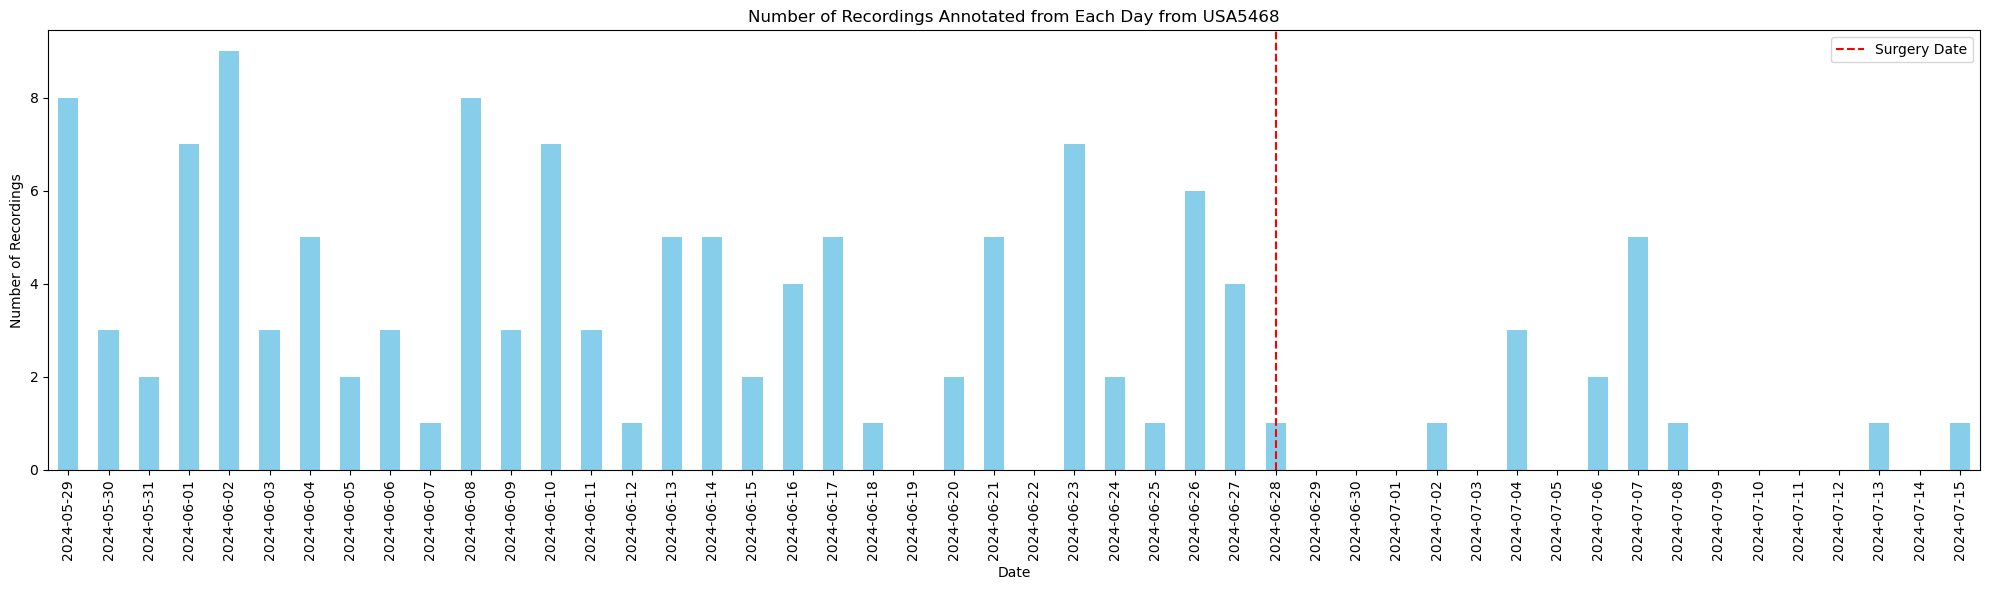

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Assuming 'annotation_data_frame' contains your dataset
df = annotation_data_frame

# Surgery date
surgery_date_reformat = pd.to_datetime(surgery_date).date()
print(f'surgery_date: {surgery_date_reformat}')

# Convert date_time to datetime format if not already done
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract just the date (without time) for each recording
df['date'] = df['date_time'].dt.date

# Count the number of recordings per day
recordings_per_day = df.groupby('date').size()

# Generate a date range from the first to the last date in the 'recordings_per_day' index
full_date_range = pd.date_range(start=recordings_per_day.index.min(), end=recordings_per_day.index.max())

# Reindex 'recordings_per_day' to include all dates in the range, filling missing dates with 0
recordings_per_day = recordings_per_day.reindex(full_date_range, fill_value=0)

# Find dates with no annotated data (i.e., days with 0 recordings)
no_data_dates = recordings_per_day[recordings_per_day == 0].index

# Convert the index (datetime) to just dates for the plot
recordings_per_day.index = recordings_per_day.index.date

# Output the missing dates in an array
no_data_dates_array = no_data_dates.date
print("Dates with no annotated data:", no_data_dates_array)

# Plot the number of recordings per day, now including missing days with 0 recordings
plt.figure(figsize=(20, 6))
recordings_per_day.plot(kind='bar', color='skyblue')

# Add a red dashed vertical line at the surgery date
if surgery_date_reformat in recordings_per_day.index:
    plt.axvline(x=list(recordings_per_day.index).index(surgery_date_reformat), color='r', linestyle='--', label='Surgery Date')
else:
    print(f"Warning: surgery_date {surgery_date_reformat} not found in recordings_per_day index.")

# Customize plot
plt.title(f'Number of Recordings Annotated from Each Day from {animal_ids[0]}')
plt.xlabel('Date')
plt.ylabel('Number of Recordings')

# Set xticks to show only the date
plt.xticks(rotation=90)
plt.gca().set_xticklabels(recordings_per_day.index)

plt.legend()
plt.tight_layout()

# Check if save_figures_TF is True before saving
if save_figures_TF:
    print(f"Saving figure to folder: {output_folder_path}")

    # Ensure the folder exists
    os.makedirs(output_folder_path, exist_ok=True)

    # Dynamically adjust the file name and folder path
    file_name = f'{output_folder_path}/{animal_ids[0]}_number_of_recordings.png'
    print(f"Saving figure as: {file_name}")

    # Save the plot as a .png file in the specified folder
    plt.savefig(file_name, format='png', dpi=300)

    # Check if the file exists after saving
    if os.path.exists(file_name):
        print(f"File saved successfully at: {file_name}")
    else:
        print("Error: File was not saved.")
else:
    print("save_figures_TF is False, skipping the save step.")

# Show the plot
plt.show()

### Graph the distribution of syllable durations across days of recording (just for display, does NOT save the figures!)

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import datetime

# df = annotation_data_frame

# # Convert date_time to datetime format
# df['date_time'] = pd.to_datetime(df['date_time'])

# # Extract dates in MM.DD format and sort by date_time
# df['date'] = df['date_time'].dt.strftime('%m.%d')
# df = df.sort_values(by='date_time')

# # Generate a fixed list of all unique dates in the dataset
# all_dates_with_annotations = df['date'].unique()

# # Convert no_data_dates to the same MM.DD format
# no_data_dates_str = [d.strftime('%m.%d') for d in no_data_dates]

# # Combine all_dates_with_annotations and no_data_dates, remove duplicates, and sort
# combined_dates = sorted(set(list(all_dates_with_annotations) + no_data_dates_str))

# # Only graph for the specified syllable label '0'
# phrase = 0  # Specify the syllable label you want to plot

# # Create a list of durations and corresponding dates for the specified syllable label
# durations = []
# dates = []

# for idx, row in df.iterrows():
#     # Extract the durations and identities for the current row
#     phrase_durations = row['phrase_durations_in_seconds']
#     phrase_identities = row['phrase_identities']
    
#     # Only keep durations where the phrase identity matches the specified syllable label '0'
#     phrase_specific_durations = [
#         dur for dur, ident in zip(phrase_durations, phrase_identities) if ident == phrase
#     ]
    
#     # Extend the durations and dates lists
#     durations.extend(phrase_specific_durations)
#     dates.extend([row['date']] * len(phrase_specific_durations))

# if len(durations) > 0:
#     plt.figure(figsize=(16, 4))

#     # Loop through each unique date and plot the durations at their corresponding position
#     for date, duration in zip(dates, durations):
#         # Find the index of the date in the combined_dates (this is where the data should be plotted)
#         x_position = combined_dates.index(date)
#         # Plot each point using the x_position
#         plt.scatter([x_position], [duration], color='b', alpha=0.6)

#     # Now add a transparent violin plot
#     # First, prepare the data for seaborn's violinplot
#     violin_data = pd.DataFrame({'date': dates, 'duration': durations})

#     # Create a violin plot over the scatterplot
#     sns.violinplot(
#         x='date', 
#         y='duration', 
#         data=violin_data, 
#         order=combined_dates,  # Ensure that the x-axis order is the same
#         scale='width',  # Scale the violin width by the number of observations
#         inner=None,  # No inner plot, we already have scatter points
#         color='b',  # Use blue color similar to scatter points
#         alpha=0.3  # Set the violin plot to be transparent
#     )

#     # Ensure the surgery date is included in the plot and draw the vertical line
#     surgery_str = surgery_date.strftime('%m.%d')
#     if surgery_str in combined_dates:
#         plt.axvline(x=combined_dates.index(surgery_str), color='r', linestyle='--', label='Surgery Date')

#     plt.title(f'Phrase Duration of Syllable Label {phrase} Across Each Day of Recording from {animal_ids[0]}')
#     plt.legend()
#     plt.xlabel('Date (MM.DD)')
#     plt.ylabel('Phrase Duration (s)')
    
#     # Set xticks to show all dates (annotated + no_data_dates)
#     plt.xticks(ticks=range(len(combined_dates)), labels=combined_dates, rotation=90)

#     plt.tight_layout()

#     # Check if save_figures_TF is True before saving
#     if save_figures_TF:
#         print(f"Saving figure to folder: {output_folder_path}")
#         os.makedirs(output_folder_path, exist_ok=True)
#         file_name = f'{output_folder_path}/{animal_ids[0]}_{phrase}_phrase_durations.png'
#         print(f"Saving figure as: {file_name}")
#         plt.savefig(file_name, format='png', dpi=300)
#         if os.path.exists(file_name):
#             print(f"File saved successfully at: {file_name}")
#         else:
#             print("Error: File was not saved.")
#     else:
#         print("save_figures_TF is False, skipping the save step.")

#     plt.show()
# else:
#     print(f"No data available for syllable label {phrase}")


In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import datetime
# import os

# df = annotation_data_frame

# # Convert date_time to datetime format
# df['date_time'] = pd.to_datetime(df['date_time'])

# # Extract dates in MM.DD format and sort by date_time
# df['date'] = df['date_time'].dt.strftime('%m.%d')
# df = df.sort_values(by='date_time')

# # Generate a fixed list of all unique dates in the dataset
# all_dates_with_annotations = df['date'].unique()

# # Convert no_data_dates to the same MM.DD format
# no_data_dates_str = [d.strftime('%m.%d') for d in no_data_dates]

# # Combine all_dates_with_annotations and no_data_dates, remove duplicates, and sort
# combined_dates = sorted(set(list(all_dates_with_annotations) + no_data_dates_str))

# # Loop through each unique syllable label
# for phrase in df['phrase_identities'].explode().unique():  # Ensure we get all unique labels

#     # Create a list of durations and corresponding dates for the current syllable label
#     durations = []
#     dates = []

#     # Loop through the rows of the DataFrame
#     for idx, row in df.iterrows():
#         # Extract the durations and identities for the current row
#         phrase_durations = row['phrase_durations_in_seconds']
#         phrase_identities = row['phrase_identities']
        
#         # Only keep durations where the phrase identity matches the current syllable label
#         phrase_specific_durations = [
#             dur for dur, ident in zip(phrase_durations, phrase_identities) if ident == phrase
#         ]
        
#         # Extend the durations and dates lists
#         durations.extend(phrase_specific_durations)
#         dates.extend([row['date']] * len(phrase_specific_durations))

#     # Only plot if there is data for the current syllable label
#     if len(durations) > 0:
#         plt.figure(figsize=(16, 4))

#         # Loop through each unique date and plot the durations at their corresponding position
#         for date, duration in zip(dates, durations):
#             # Find the index of the date in the combined_dates (this is where the data should be plotted)
#             x_position = combined_dates.index(date)
#             # Plot each point using the x_position
#             plt.scatter([x_position], [duration], color='b', alpha=0.6)

#         # Now add a transparent violin plot
#         # First, prepare the data for seaborn's violinplot
#         violin_data = pd.DataFrame({'date': dates, 'duration': durations})

#         # Create a violin plot over the scatterplot
#         sns.violinplot(
#             x='date', 
#             y='duration', 
#             data=violin_data, 
#             order=combined_dates,  # Ensure that the x-axis order is the same
#             scale='width',  # Scale the violin width by the number of observations
#             inner=None,  # No inner plot, we already have scatter points
#             color='b',  # Use blue color similar to scatter points
#             alpha=0.3  # Set the violin plot to be transparent
#         )

#         # Ensure the surgery date is included in the plot and draw the vertical line
#         surgery_str = surgery_date.strftime('%m.%d')
#         if surgery_str in combined_dates:
#             plt.axvline(x=combined_dates.index(surgery_str), color='r', linestyle='--', label='Surgery Date')

#         plt.title(f'Phrase Duration of Syllable Label {phrase} Across Each Day of Recording from {animal_ids[0]}')
#         plt.legend()
#         plt.xlabel('Date (MM.DD)')
#         plt.ylabel('Phrase Duration (s)')
        
#         # Set xticks to show all dates (annotated + no_data_dates)
#         plt.xticks(ticks=range(len(combined_dates)), labels=combined_dates, rotation=90)

#         plt.tight_layout()

#         # Check if save_figures_TF is True before saving
#         if save_figures_TF:
#             print(f"Saving figure to folder: {output_folder_path}")
#             os.makedirs(output_folder_path, exist_ok=True)
#             file_name = f'{output_folder_path}/{animal_ids[0]}_{phrase}_phrase_durations.png'
#             print(f"Saving figure as: {file_name}")
#             plt.savefig(file_name, format='png', dpi=300)
#             if os.path.exists(file_name):
#                 print(f"File saved successfully at: {file_name}")
#             else:
#                 print("Error: File was not saved.")
#         else:
#             print("save_figures_TF is False, skipping the save step.")

#         plt.show()
#     else:
#         print(f"No data available for syllable label {phrase}")


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_10_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_10_phrase_durations.png


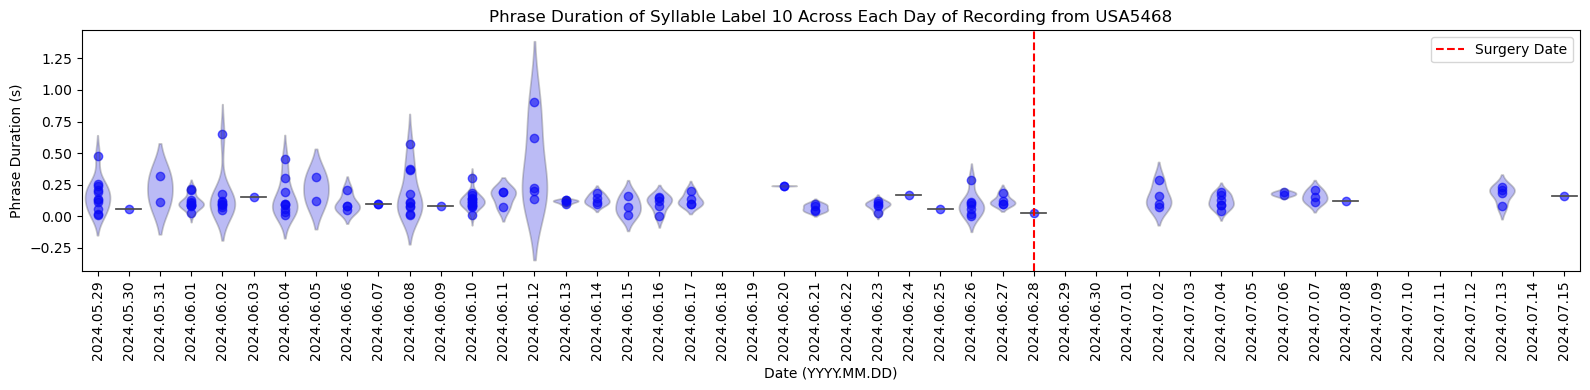

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_8_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_8_phrase_durations.png


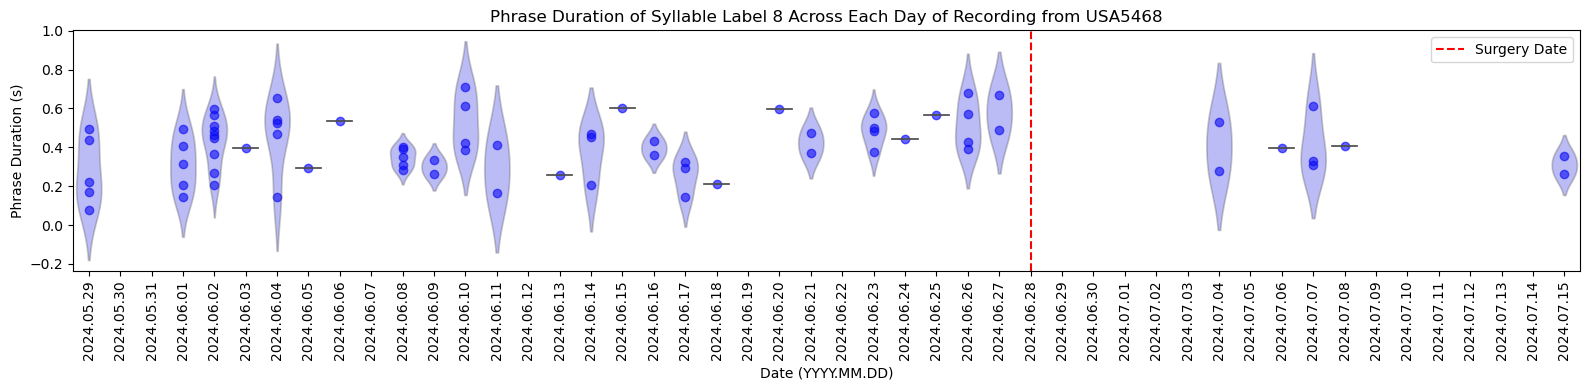

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_9_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_9_phrase_durations.png


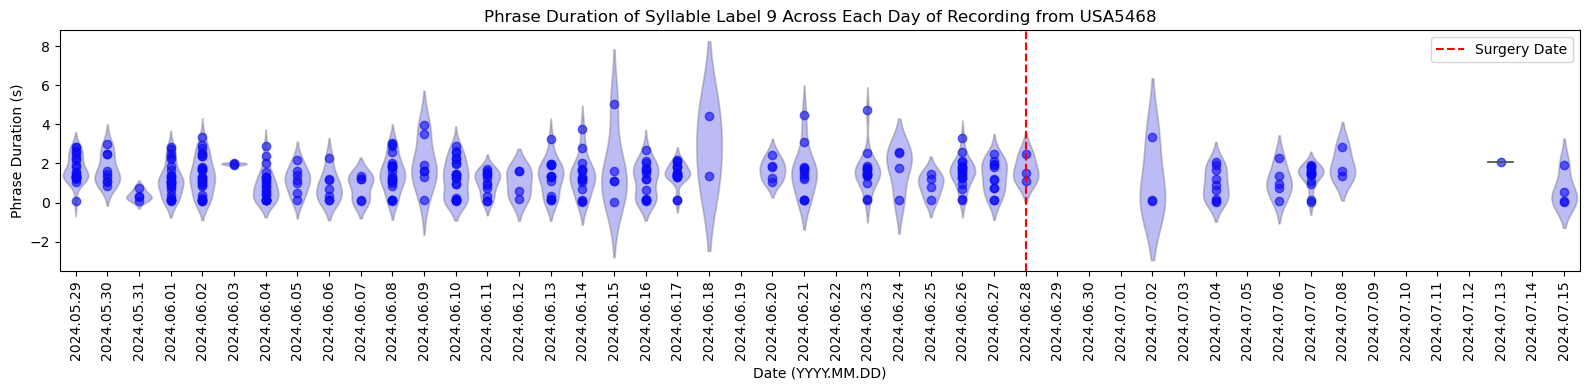

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_18_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_18_phrase_durations.png


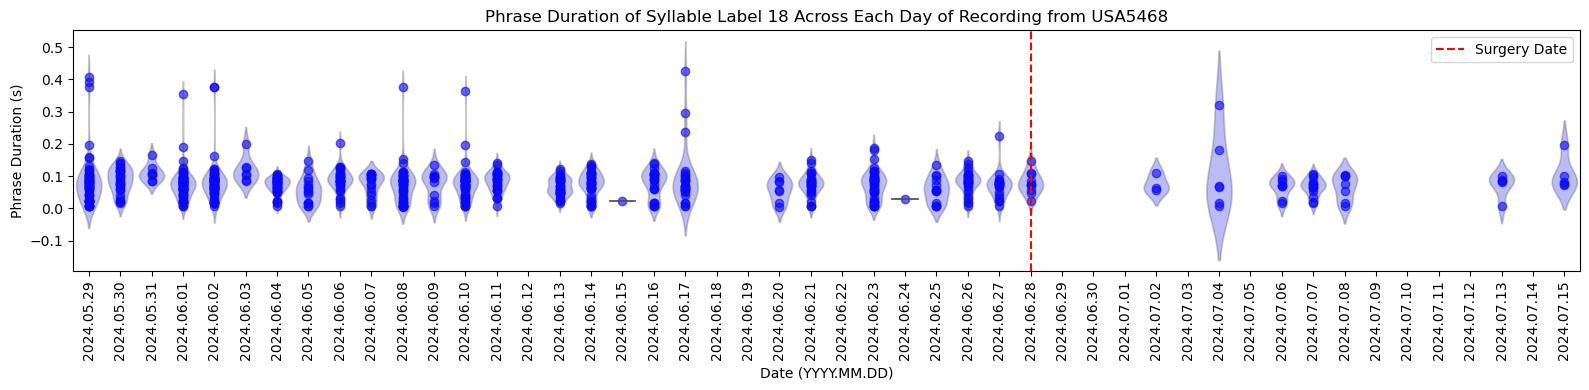

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_15_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_15_phrase_durations.png


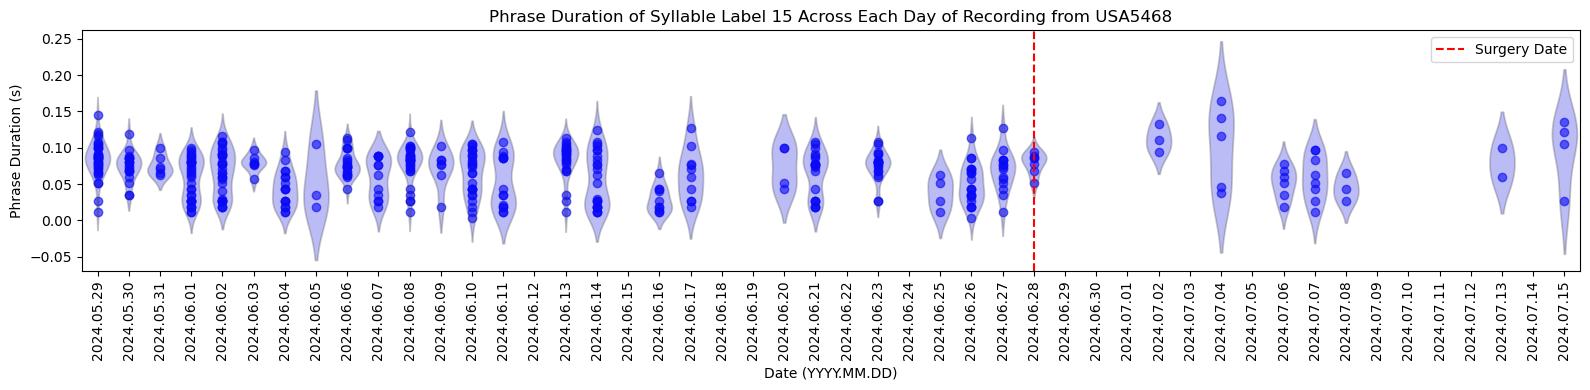

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_21_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_21_phrase_durations.png


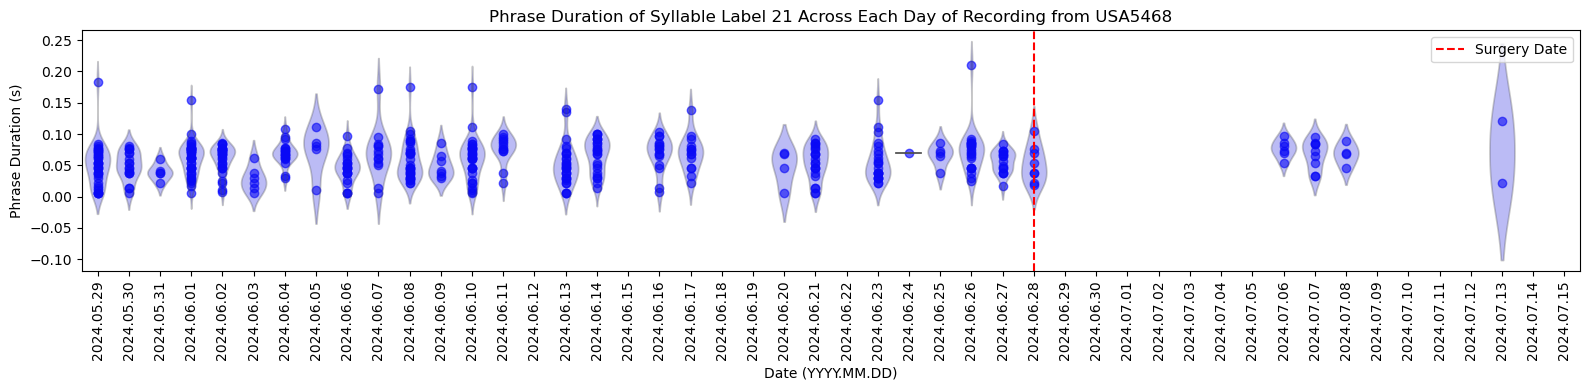

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_20_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_20_phrase_durations.png


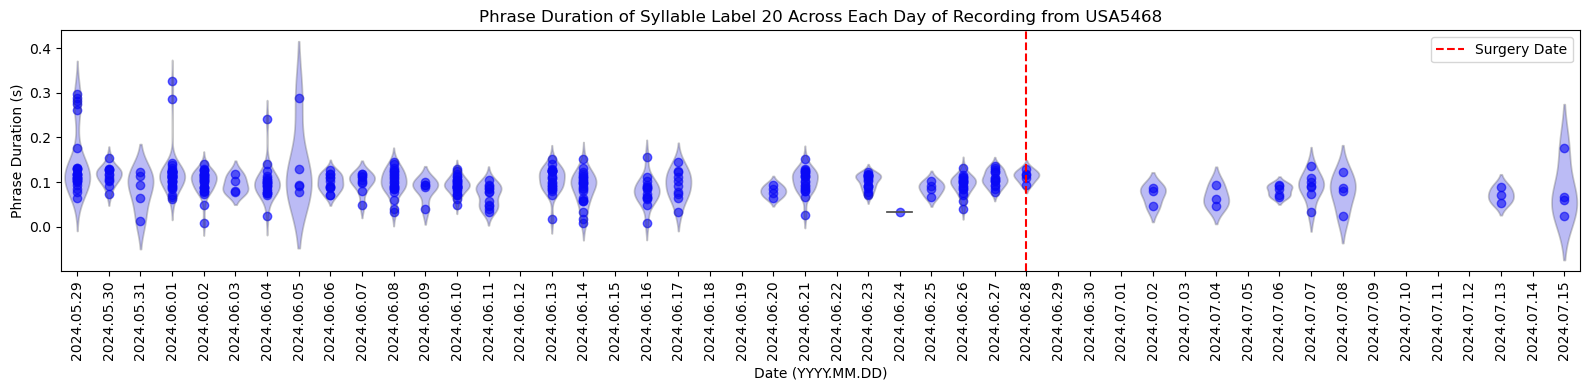

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_12_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_12_phrase_durations.png


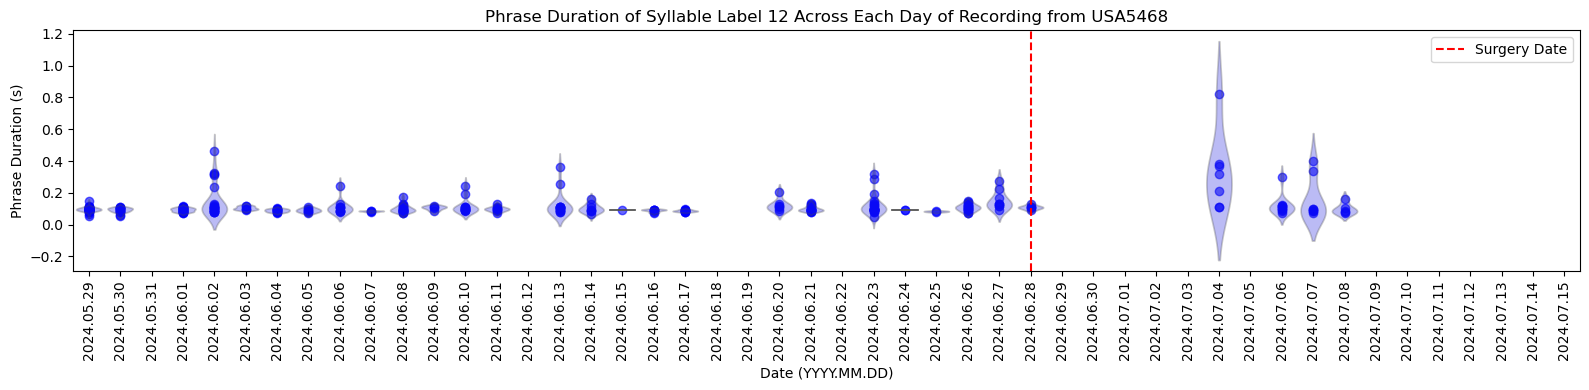

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_13_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_13_phrase_durations.png


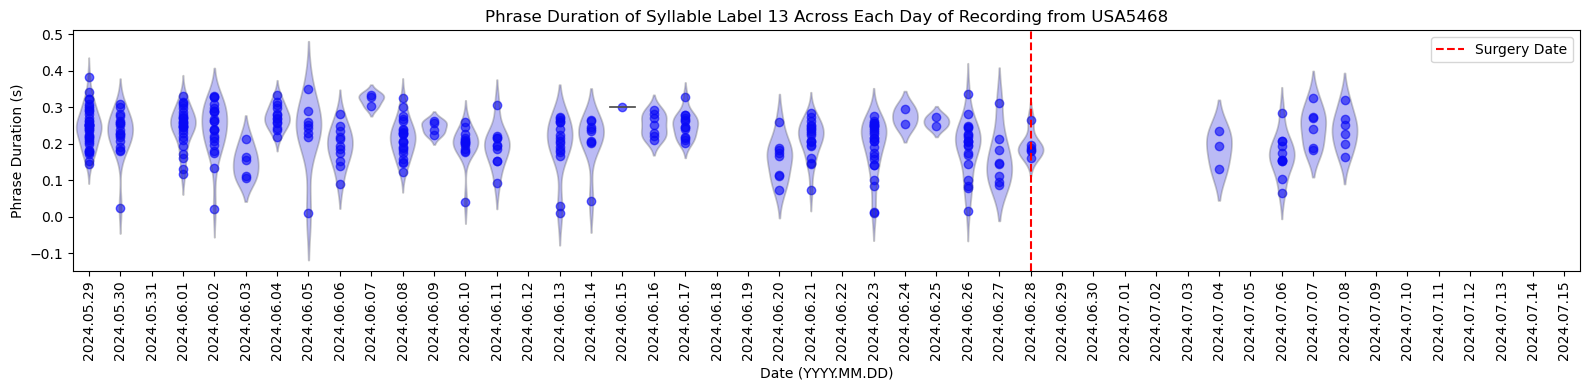

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_11_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_11_phrase_durations.png


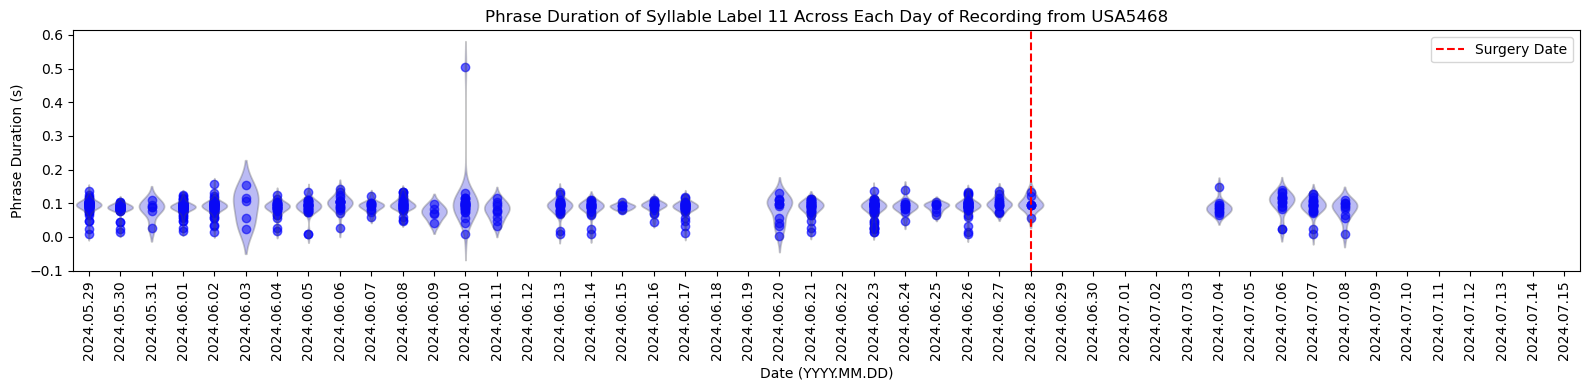

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_7_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_7_phrase_durations.png


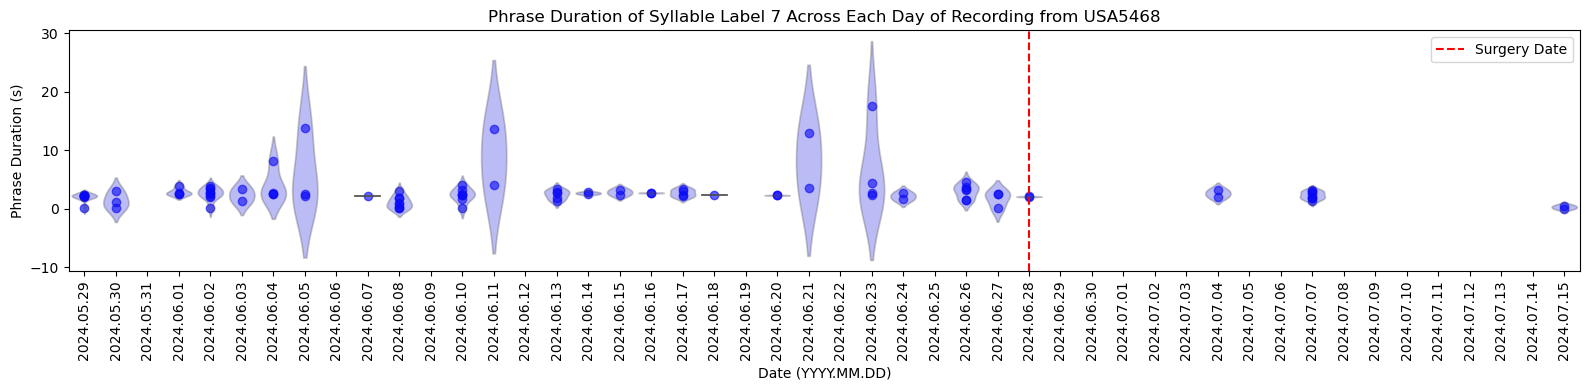

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_19_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_19_phrase_durations.png


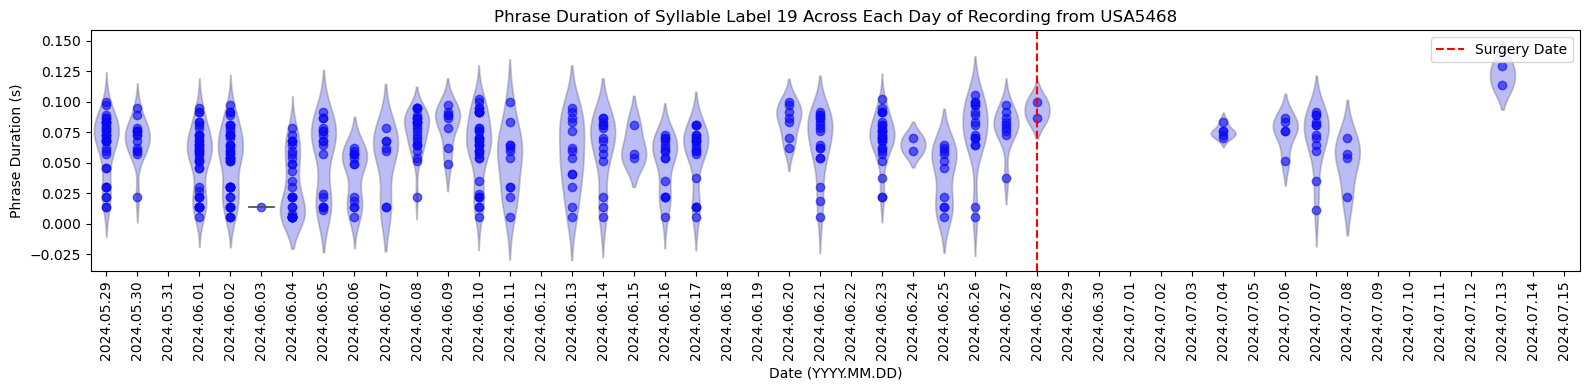

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_17_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_17_phrase_durations.png


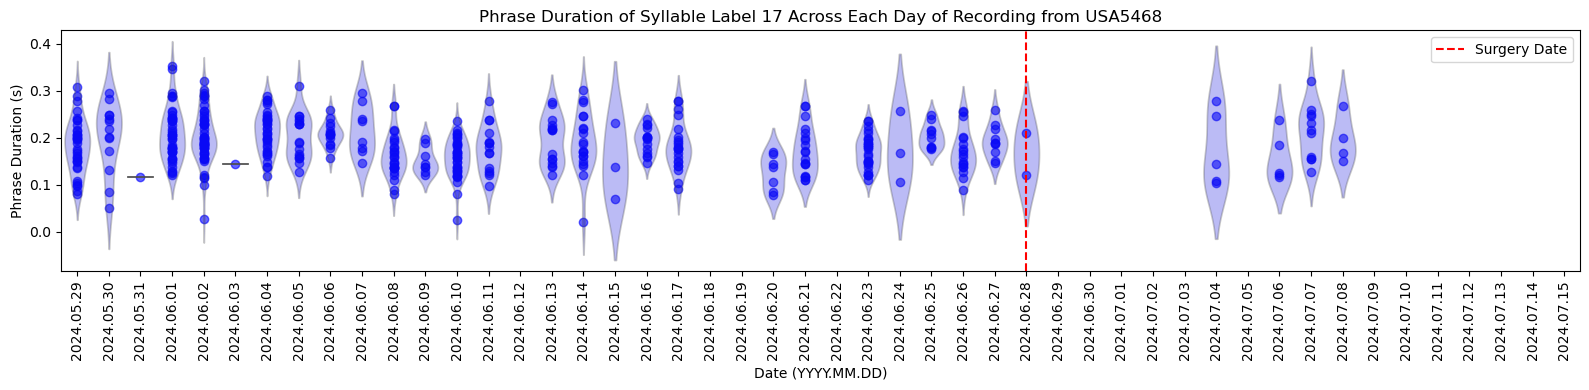

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_16_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_16_phrase_durations.png


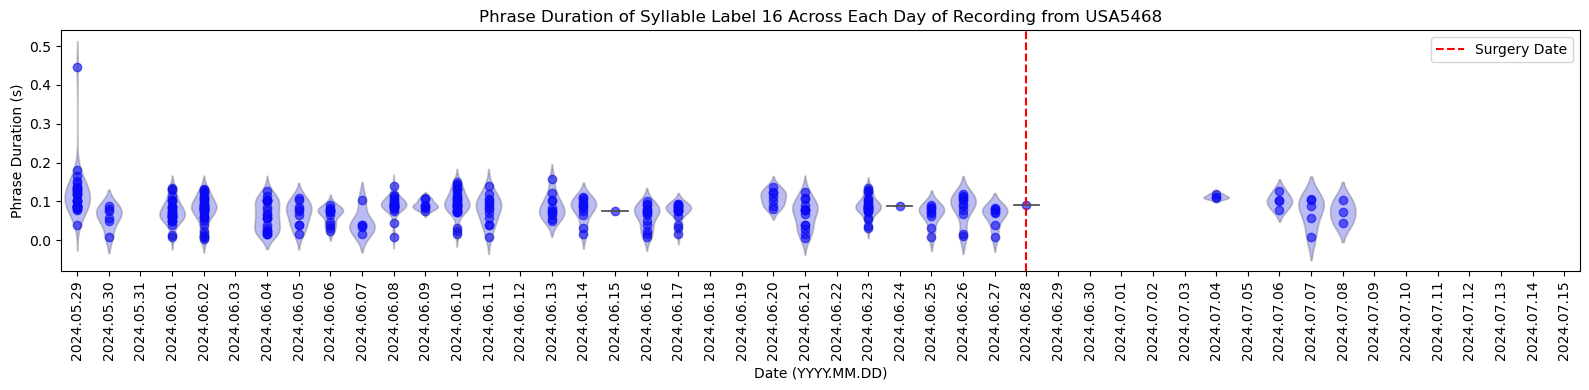

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_14_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_14_phrase_durations.png


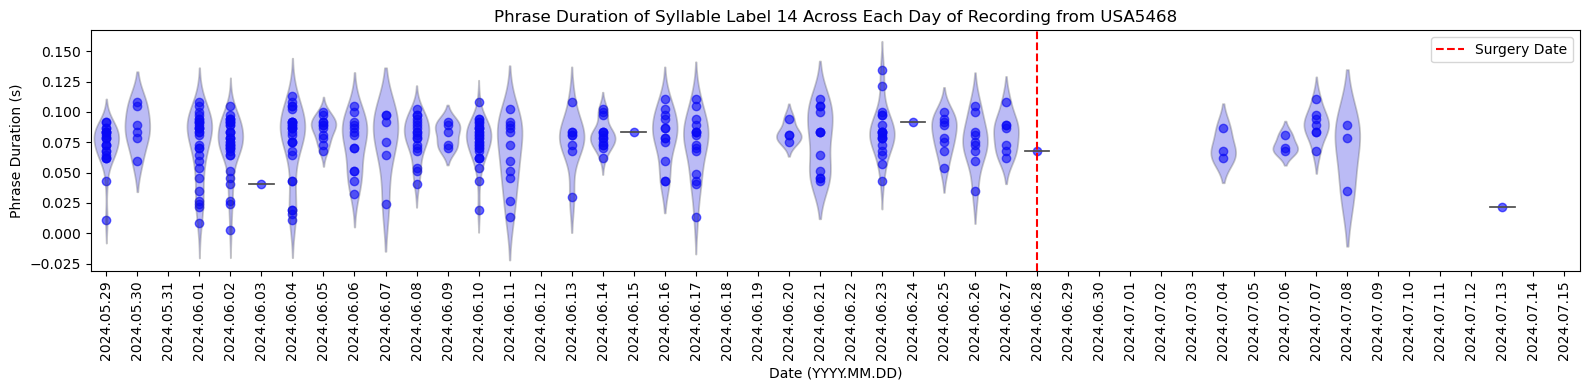

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_5_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_5_phrase_durations.png


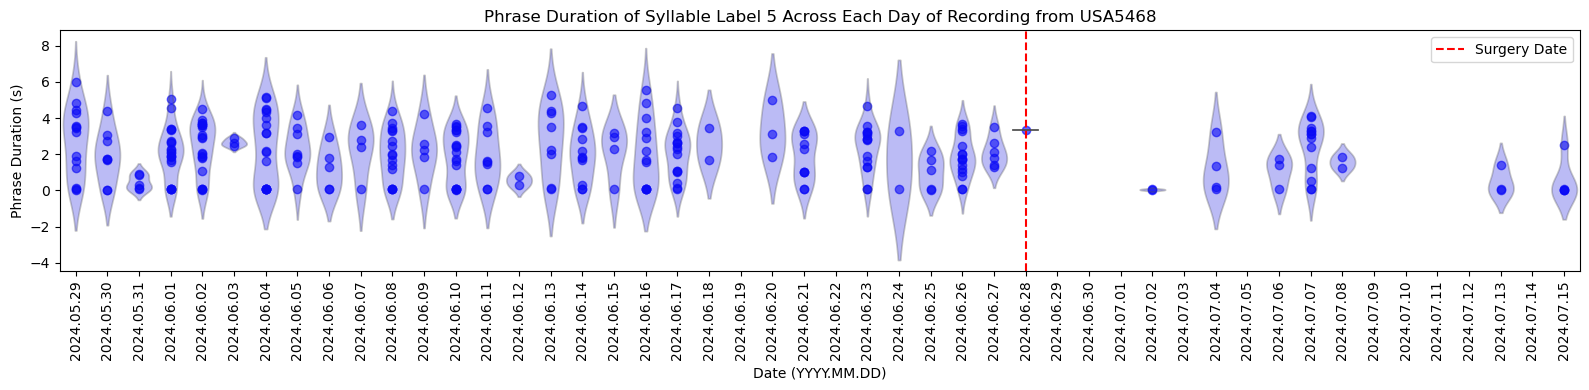

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_6_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_6_phrase_durations.png


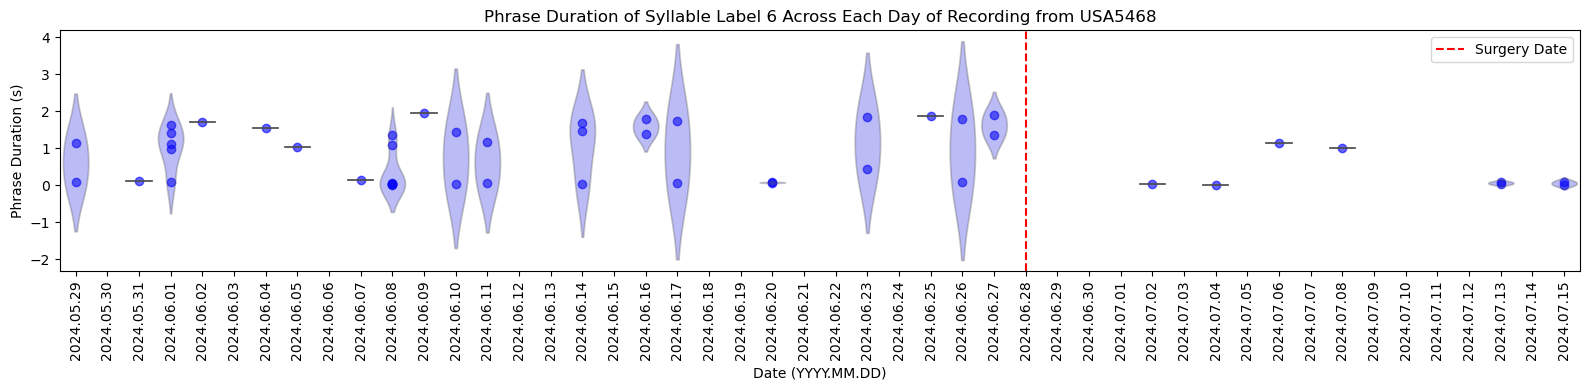

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_4_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_4_phrase_durations.png


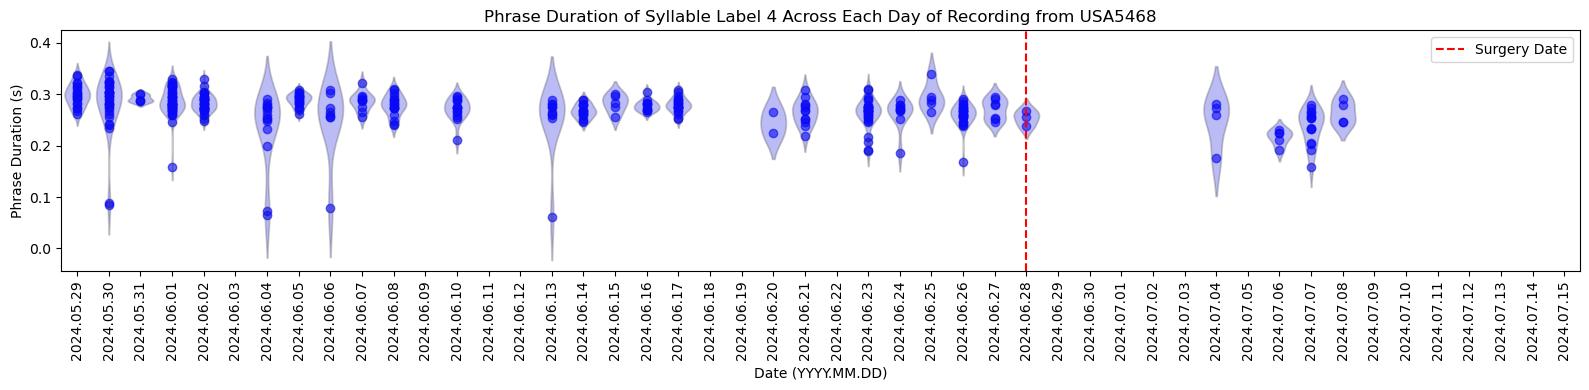

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_2_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_2_phrase_durations.png


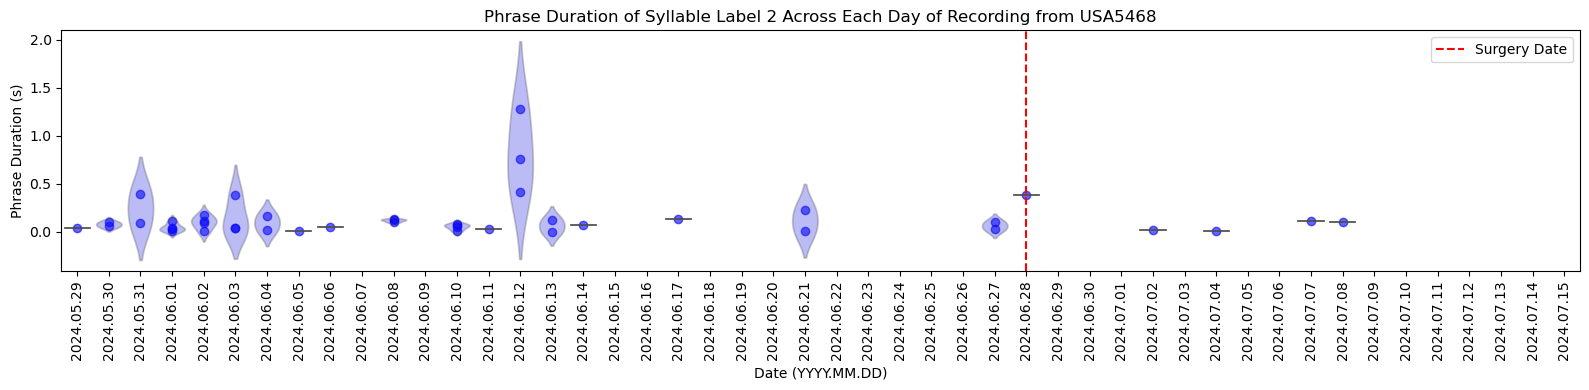

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_3_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_3_phrase_durations.png


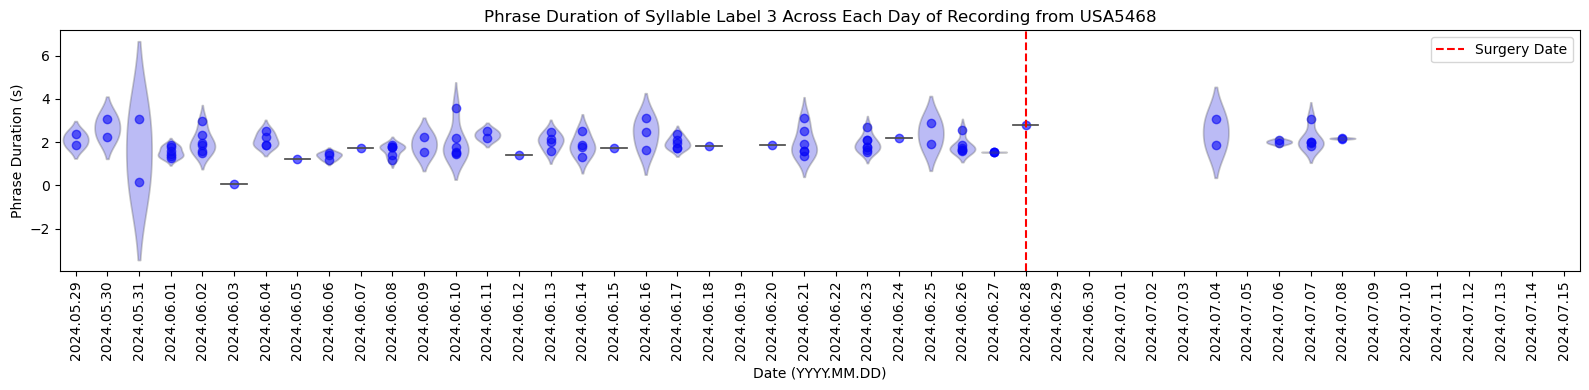

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_1_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_1_phrase_durations.png


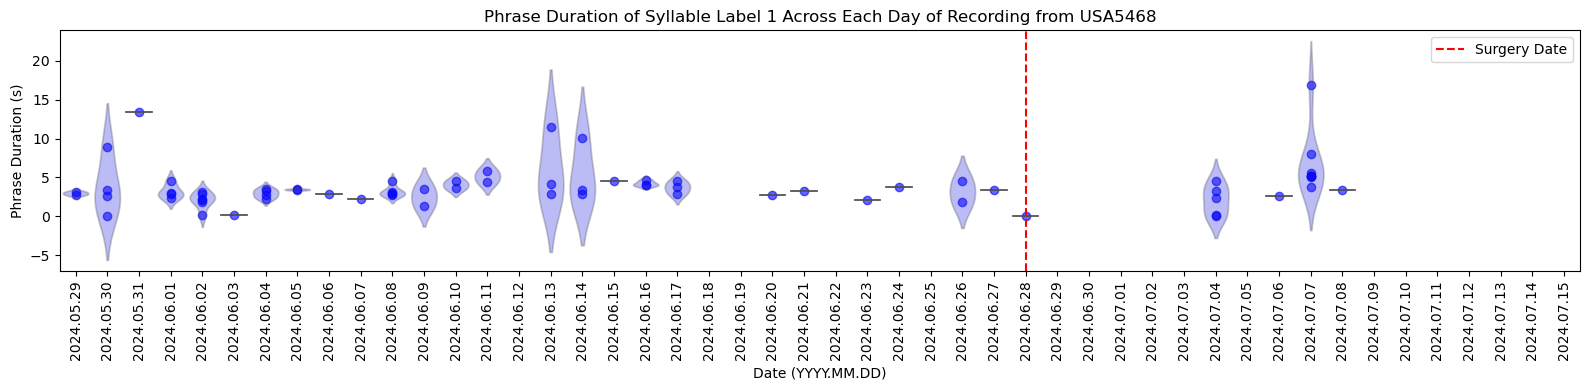

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_61467/2565175817.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_0_phrase_durations.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5468_output_graphs/USA5468_0_phrase_durations.png


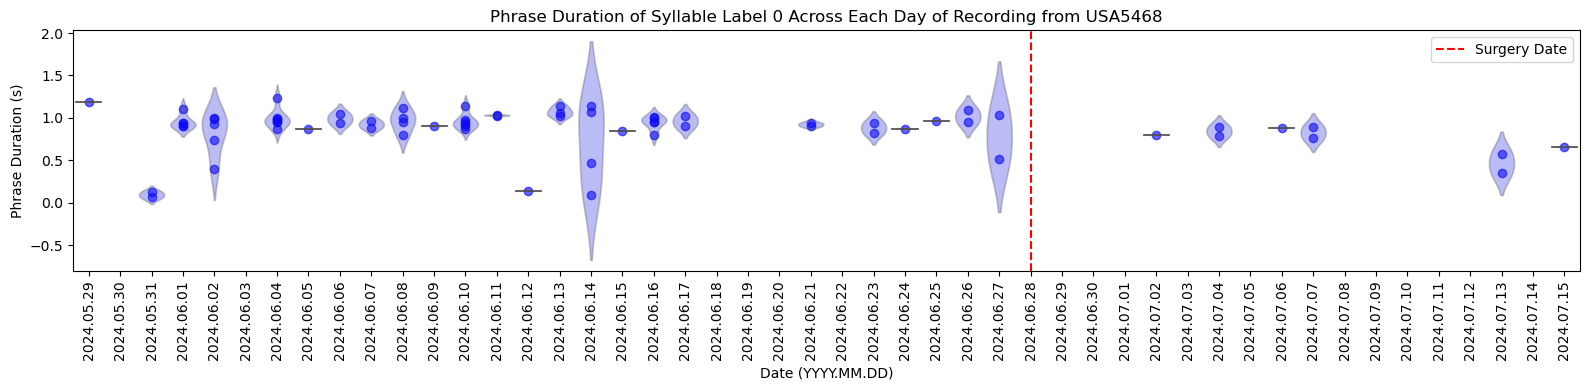

In [58]:
# Extract dates in YYYY.MM.DD format and sort by date_time
df['date'] = df['date_time'].dt.strftime('%Y.%m.%d')
df = df.sort_values(by='date_time')

# Generate a fixed list of all unique dates in the dataset
all_dates_with_annotations = df['date'].unique()

# Convert no_data_dates to the same YYYY.MM.DD format
no_data_dates_str = [d.strftime('%Y.%m.%d') for d in no_data_dates]

# Combine all_dates_with_annotations and no_data_dates, remove duplicates, and sort
combined_dates = sorted(set(list(all_dates_with_annotations) + no_data_dates_str))

# Loop through each unique syllable label
for phrase in df['phrase_identities'].explode().unique():  # Ensure we get all unique labels

    # Create a list of durations and corresponding dates for the current syllable label
    durations = []
    dates = []

    # Loop through the rows of the DataFrame
    for idx, row in df.iterrows():
        # Extract the durations and identities for the current row
        phrase_durations = row['phrase_durations_in_seconds']
        phrase_identities = row['phrase_identities']
        
        # Only keep durations where the phrase identity matches the current syllable label
        phrase_specific_durations = [
            dur for dur, ident in zip(phrase_durations, phrase_identities) if ident == phrase
        ]
        
        # Extend the durations and dates lists
        durations.extend(phrase_specific_durations)
        dates.extend([row['date']] * len(phrase_specific_durations))

    # Only plot if there is data for the current syllable label
    if len(durations) > 0:
        plt.figure(figsize=(16, 4))

        # Loop through each unique date and plot the durations at their corresponding position
        for date, duration in zip(dates, durations):
            # Find the index of the date in the combined_dates (this is where the data should be plotted)
            x_position = combined_dates.index(date)
            # Plot each point using the x_position
            plt.scatter([x_position], [duration], color='b', alpha=0.6)

        # Now add a transparent violin plot
        # First, prepare the data for seaborn's violinplot
        violin_data = pd.DataFrame({'date': dates, 'duration': durations})

        # Create a violin plot over the scatterplot
        sns.violinplot(
            x='date', 
            y='duration', 
            data=violin_data, 
            order=combined_dates,  # Ensure that the x-axis order is the same
            scale='width',  # Scale the violin width by the number of observations
            inner=None,  # No inner plot, we already have scatter points
            color='b',  # Use blue color similar to scatter points
            alpha=0.3  # Set the violin plot to be transparent
        )

        # Ensure the surgery date is included in the plot and draw the vertical line
        surgery_str = surgery_date.strftime('%Y.%m.%d')
        if surgery_str in combined_dates:
            plt.axvline(x=combined_dates.index(surgery_str), color='r', linestyle='--', label='Surgery Date')

        plt.title(f'Phrase Duration of Syllable Label {phrase} Across Each Day of Recording from {animal_ids[0]}')
        plt.legend()
        plt.xlabel('Date (YYYY.MM.DD)')
        plt.ylabel('Phrase Duration (s)')
        
        # Set xticks to show all dates (annotated + no_data_dates)
        plt.xticks(ticks=range(len(combined_dates)), labels=combined_dates, rotation=90)

        plt.tight_layout()

        # Check if save_figures_TF is True before saving
        if save_figures_TF:
            print(f"Saving figure to folder: {output_folder_path}")
            os.makedirs(output_folder_path, exist_ok=True)
            file_name = f'{output_folder_path}/{animal_ids[0]}_{phrase}_phrase_durations.png'
            print(f"Saving figure as: {file_name}")
            plt.savefig(file_name, format='png', dpi=300)
            if os.path.exists(file_name):
                print(f"File saved successfully at: {file_name}")
            else:
                print("Error: File was not saved.")
        else:
            print("save_figures_TF is False, skipping the save step.")

        plt.show()
    else:
        print(f"No data available for syllable label {phrase}")
